In [151]:
import pandas as pd 
import numpy as np 
import glob
import matplotlib.pyplot as plt
from time import time

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer

# Differnt types of Naive Bayes Classifiers
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB

pd.set_option('display.max_columns', None)

In [121]:
df = pd.read_csv('../kickstarter_train_final_20221015-012651.csv')
test = pd.read_csv('../kickstarter_test_final_20221015-012736.csv')

In [123]:
scaler = MinMaxScaler() 
df[['reward_tiers', 'min_reward', 'max_reward', 'goal']] = scaler.fit_transform(df[['reward_tiers', 'min_reward', 'max_reward', 'goal']])
test[['reward_tiers', 'min_reward', 'max_reward', 'goal']] = scaler.transform(test[['reward_tiers', 'min_reward', 'max_reward', 'goal']])

## Get to the correct data format

In [124]:
to_drop = ['rewards', 'deadline', 'launched_at', 'rewards_processed', 'created_at',
           'description_processed', 'description_story_processed','description_risks_processed',
           'id', 'name', 'description', 'description_story', 'description_risks', 'video', 'state']

X_train, y_train = df.drop(to_drop, axis=1).iloc[:, :419], df['state']
X_test, y_test = test.drop(to_drop, axis=1).iloc[:, :419], test['state']

## Mixed NB Approach 1 
convert continuous variables into categorical ones through binning and then train a categorical model

In [127]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()
binary_cols = ['staff_pick', 'has_video']
train_numeric = X_train1.select_dtypes(include='number').drop(binary_cols, axis=1) 
test_numeric = X_test1.select_dtypes(include='number').drop(binary_cols, axis=1) 

In [128]:
for i, col in enumerate(train_numeric.columns):
    X_train1[col], val = pd.qcut(X_train1[col], , retbins = True, duplicates = 'drop')
    X_test1[col] = pd.cut(X_test1[col], bins = val, duplicates = 'drop', include_lowest=True)

In [130]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
X_train1_fitted = enc.fit_transform(X_train1)
X_test1_fitted = enc.transform(X_test1)
imp = SimpleImputer(strategy="most_frequent") # impute nan values
X_train1_fitted = imp.fit_transform(X_train1_fitted)
X_test1_fitted = imp.transform(X_test1_fitted)
model_C = CategoricalNB()
clf_C = model_C.fit(X_train1_fitted, y_train)
y_pred = model_C.predict(X_test1_fitted)

In [131]:
# train classification report
y_train_pred = model_C.predict(X_train1_fitted)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.65      0.80      0.72      7274
           1       0.91      0.82      0.86     17482

    accuracy                           0.81     24756
   macro avg       0.78      0.81      0.79     24756
weighted avg       0.83      0.81      0.82     24756



In [132]:
# test classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71      1282
           1       0.91      0.82      0.86      3087

    accuracy                           0.81      4369
   macro avg       0.78      0.81      0.79      4369
weighted avg       0.83      0.81      0.82      4369



In [133]:
y_pred_prob = model_C.predict_proba(X_test1_fitted)[:, 1]
print('ROC_AUC: ', roc_auc_score(y_test, y_pred_prob))

ROC_AUC:  0.8935339532142995


## Mixed NB Approach 2
train three separate models using continuous, binary and categorical variables and then train the final model based on predictions from the first three models

In [134]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()
categorical_cols = ['category', 'location']
train_binary = X_train2[binary_cols]
train_categorical = X_train2[categorical_cols]
test_binary = X_test2[binary_cols]
test_categorical = X_test2[categorical_cols]

In [135]:
# ----- Fit three models -----

model_G = GaussianNB()
clf_G = model_G.fit(train_numeric, y_train)

model_C2 = CategoricalNB()
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
train_categorical = enc.fit_transform(train_categorical)
test_categorical = enc.transform(test_categorical)
imp = SimpleImputer(strategy="most_frequent") 
train_categorical = imp.fit_transform(train_categorical)
test_categorical = imp.transform(test_categorical)
clf_C2 = model_C2.fit(train_categorical, y_train)

model_B = BernoulliNB()
clf_B = model_B.fit(train_binary, y_train)

# ----- Get probability predictions from each model -----
# On training data
G_train_probas = model_G.predict_proba(train_numeric)
C_train_probas = model_C2.predict_proba(train_categorical)
B_train_probas = model_B.predict_proba(train_binary)

# And on testing data
G_test_probas = model_G.predict_proba(test_numeric)
C_test_probas = model_C2.predict_proba(test_categorical)
B_test_probas = model_B.predict_proba(test_binary)

# Combine probability prediction for class=1 from both models
X_new_train = np.c_[(G_train_probas[:,1], C_train_probas[:,1], B_train_probas[:,1])] # Train
X_new_test = np.c_[(G_test_probas[:,1], C_test_probas[:,1], B_test_probas[:,1])] # Test


# ----- Fit Gaussian model on the X_new -----
model = GaussianNB()
clf = model.fit(X_new_train, y_train)
y_pred = model.predict(X_new_test)

In [136]:
# train classification report
y_train_pred = model.predict(X_new_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      7274
           1       0.89      0.83      0.86     17482

    accuracy                           0.81     24756
   macro avg       0.77      0.80      0.78     24756
weighted avg       0.82      0.81      0.81     24756



In [137]:
# test classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      1282
           1       0.89      0.83      0.86      3087

    accuracy                           0.81      4369
   macro avg       0.77      0.79      0.78      4369
weighted avg       0.82      0.81      0.81      4369



In [138]:
y_pred_prob = model.predict_proba(X_new_test)[:, 1]
print('ROC_AUC: ', roc_auc_score(y_test, y_pred_prob))

ROC_AUC:  0.8491033810448627


## Hyperparameter Tuning

For approach 1:

In [139]:
param_grid1_nb = {
    'alpha': np.logspace(0,-9, num=100)
}
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [140]:
model_grid1 = GridSearchCV(estimator = CategoricalNB(), 
                            param_grid = param_grid1_nb, 
                            verbose = 1, 
                            cv = cv_method,
                            scoring = 'accuracy')
model_grid1.fit(X_train1_fitted, y_train)
print('--------------------------------------------------------')
print('Best Estimator: ', model_grid1.best_estimator_)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
--------------------------------------------------------
Best Estimator:  CategoricalNB()


In [141]:
# train classification report
y_train_pred = model_grid1.predict(X_train1_fitted)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.65      0.80      0.72      7274
           1       0.91      0.82      0.86     17482

    accuracy                           0.81     24756
   macro avg       0.78      0.81      0.79     24756
weighted avg       0.83      0.81      0.82     24756



In [142]:
# test classification report
y_pred = model_grid1.predict(X_test1_fitted)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71      1282
           1       0.91      0.82      0.86      3087

    accuracy                           0.81      4369
   macro avg       0.78      0.81      0.79      4369
weighted avg       0.83      0.81      0.82      4369



In [144]:
y_pred_prob = model_grid1.predict_proba(X_test1_fitted)[:, 1]
print('ROC_AUC: ', roc_auc_score(y_test, y_pred_prob))

ROC_AUC:  0.8935339532142995


For approach 2:

In [145]:
param_grid2_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [146]:
model_grid2 = GridSearchCV(estimator = GaussianNB(), 
                            param_grid = param_grid2_nb, 
                            verbose = 1, 
                            cv = cv_method,
                            scoring = 'accuracy')
model_grid2.fit(X_new_train, y_train)
print('--------------------------------------------------------')
print('Best Estimator: ', model_grid2.best_estimator_)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
--------------------------------------------------------
Best Estimator:  GaussianNB(var_smoothing=0.533669923120631)


In [147]:
# train classification report
y_train_pred = model_grid2.predict(X_new_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.67      0.72      0.70      7274
           1       0.88      0.85      0.87     17482

    accuracy                           0.82     24756
   macro avg       0.78      0.79      0.78     24756
weighted avg       0.82      0.82      0.82     24756



In [148]:
# test classification report
y_pred = model_grid2.predict(X_new_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1282
           1       0.88      0.86      0.87      3087

    accuracy                           0.82      4369
   macro avg       0.78      0.79      0.78      4369
weighted avg       0.82      0.82      0.82      4369



In [149]:
y_pred_prob = model_grid2.predict_proba(X_new_test)[:, 1]
print('ROC_AUC: ', roc_auc_score(y_test, y_pred_prob))

ROC_AUC:  0.8488053419124131


## Best NB Model
Approach 1 gives a higher ROC_AUC score, with hyperparameter tuning making no significant difference to its performance.

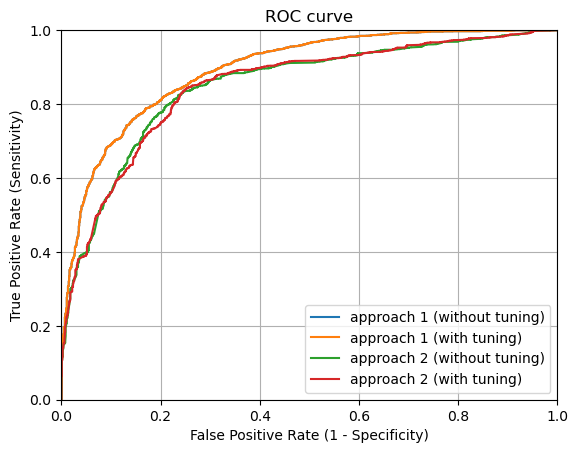

In [152]:
y_pred_prob1 = model_C.predict_proba(X_test1_fitted)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob1)
y_pred_prob2 = model_grid1.predict_proba(X_test1_fitted)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_prob2)
y_pred_prob3 = model.predict_proba(X_new_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, y_pred_prob3)
y_pred_prob4 = model_grid2.predict_proba(X_new_test)[:, 1]
fpr4, tpr4, thresholds = roc_curve(y_test, y_pred_prob4)
plt.plot(fpr1, tpr1, label = "approach 1 (without tuning)")
plt.plot(fpr2, tpr2, label ="approach 1 (with tuning)")
plt.plot(fpr3, tpr3, label = "approach 2 (without tuning)")
plt.plot(fpr4, tpr4, label ="approach 2 (with tuning)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)

## Run time

In [153]:
start_time = time()
model_time = CategoricalNB()
clf_best = model_time.fit(X_train1_fitted, y_train)
y_pred = model_time.predict(X_test1_fitted)
run_time = time() - start_time
print("Run time: ", run_time)

Run time:  0.5874333381652832
